In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy as sp

%matplotlib inline
sns.set()
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
submission = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv')

ntrain = train.shape[0]
ntest = test.shape[0]

with open('/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt', 'r') as file:
    description = file.read()

#print(description)

In [4]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [6]:
submission.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [7]:
any(train.Id) == any(test.Id)

True

Cannot combine the train and test datasets due to conflicting Ids during pre-processing.

In [8]:
print(train.info())
print(train.shape)
print('*'*40)
print(test.info())
print(test.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Alley, FireplaceQu, PoolQC, Fence and MiscFeature appears to have many missing values, that is something to take note of.

In [9]:
train_ID = train['Id']
test_ID = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

Id is not useful in the modelling process.

In [10]:
print(train.describe())
print('*'*40)
print(test.describe())

        MSSubClass  LotFrontage        LotArea  OverallQual  OverallCond  \
count  1460.000000  1201.000000    1460.000000  1460.000000  1460.000000   
mean     56.897260    70.049958   10516.828082     6.099315     5.575342   
std      42.300571    24.284752    9981.264932     1.382997     1.112799   
min      20.000000    21.000000    1300.000000     1.000000     1.000000   
25%      20.000000    59.000000    7553.500000     5.000000     5.000000   
50%      50.000000    69.000000    9478.500000     6.000000     5.000000   
75%      70.000000    80.000000   11601.500000     7.000000     6.000000   
max     190.000000   313.000000  215245.000000    10.000000     9.000000   

         YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1   BsmtFinSF2  ...  \
count  1460.000000   1460.000000  1452.000000  1460.000000  1460.000000  ...   
mean   1971.267808   1984.865753   103.685262   443.639726    46.549315  ...   
std      30.202904     20.645407   181.066207   456.098091   161.319273  ..

In [11]:
num_cols = train.select_dtypes('number').columns
obj_cols = train.select_dtypes('object').columns

In [12]:
train[num_cols]

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,62.0,7917,6,5,1999,2000,0.0,0,0,...,0,40,0,0,0,0,0,8,2007,175000
1456,20,85.0,13175,6,6,1978,1988,119.0,790,163,...,349,0,0,0,0,0,0,2,2010,210000
1457,70,66.0,9042,7,9,1941,2006,0.0,275,0,...,0,60,0,0,0,0,2500,5,2010,266500
1458,20,68.0,9717,5,6,1950,1996,0.0,49,1029,...,366,0,112,0,0,0,0,4,2010,142125


In [13]:
train[obj_cols]

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1456,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,...,Attchd,Unf,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
1457,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,...,Attchd,RFn,TA,TA,Y,NaN,GdPrv,Shed,WD,Normal
1458,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Normal


## Continuous features

In [14]:
# fig, axes = plt.subplots(len(num_cols), 1, figsize=(8, 4 * len(num_cols)))

# for i, col in enumerate(num_cols):
#     sns.histplot(data=train, x=col, ax=axes[i], kde = True)
#     axes[i].set_title(col)

# plt.tight_layout()
# plt.show()

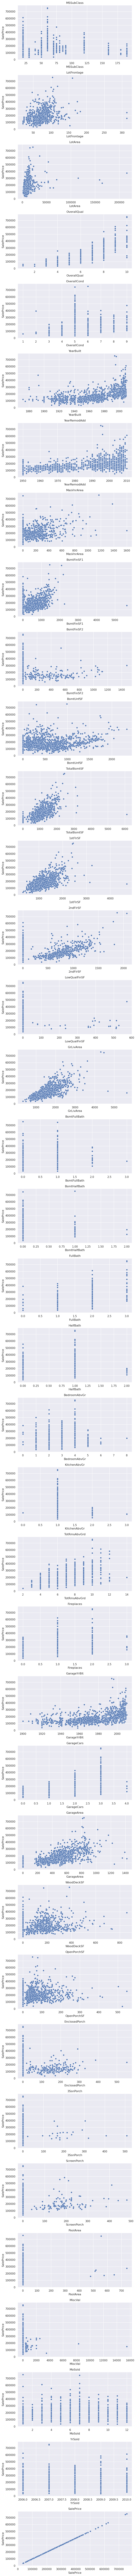

In [15]:
fig, axes = plt.subplots(len(num_cols), 1, figsize=(8, 4 * len(num_cols)))

for i, col in enumerate(num_cols):
    sns.scatterplot(data=train, x=col, y='SalePrice', ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

## Categorical features

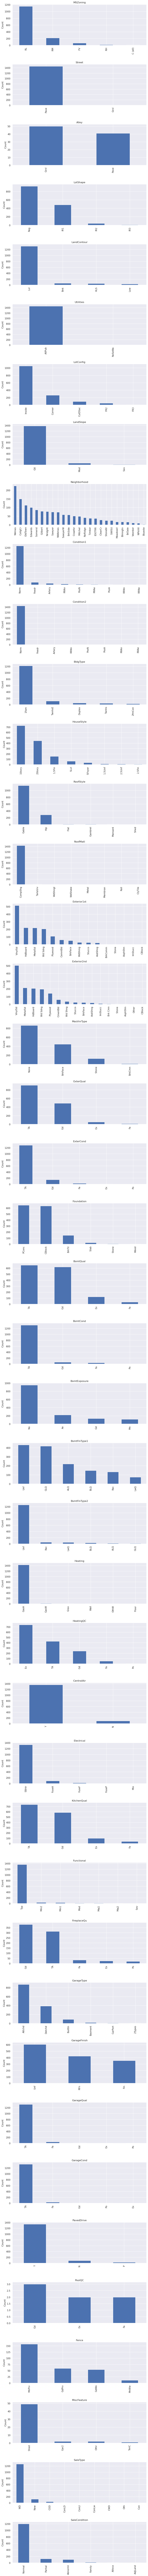

In [16]:
fig, axes = plt.subplots(len(obj_cols), 1, figsize = (10, 4 * len(obj_cols)))
for i, col in enumerate(obj_cols):
    train[col].value_counts().plot(kind='bar', ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_ylabel("Count")
    
plt.tight_layout()
plt.show()

In [17]:
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])

In [18]:
ntrain = train.shape[0]
ntest = test.shape[0]
y = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


# Missing values

In [19]:
all_data['PoolQC'].fillna('None',inplace = True)
all_data['Alley'].fillna('None',inplace = True)
all_data['MiscFeature'].fillna('None',inplace = True)
all_data['Fence'].fillna('None', inplace = True)
all_data['FireplaceQu'].fillna('None', inplace = True)

all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
lambda x: x.fillna(x.median()))

all_data['GarageType'].fillna('None',inplace = True)
all_data['GarageFinish'].fillna('None',inplace = True)
all_data['GarageQual'].fillna('None', inplace = True)
all_data['GarageCond'].fillna('None', inplace = True)

all_data['GarageYrBlt'].fillna(0,inplace = True)
all_data['GarageArea'].fillna(0,inplace = True)
all_data['GarageCars'].fillna(0, inplace = True)

all_data['BsmtFinSF1'].fillna(0,inplace = True)
all_data['BsmtFinSF2'].fillna(0,inplace = True)
all_data['BsmtUnfSF'].fillna(0, inplace = True)
all_data['TotalBsmtSF'].fillna(0,inplace = True)
all_data['BsmtFullBath'].fillna(0,inplace = True)
all_data['BsmtHalfBath'].fillna(0,inplace = True)

all_data['BsmtQual'].fillna('None',inplace = True)
all_data['BsmtCond'].fillna('None',inplace = True)
all_data['BsmtExposure'].fillna('None', inplace = True)
all_data['BsmtFinType1'].fillna('None', inplace = True)
all_data['BsmtFinType2'].fillna('None', inplace = True)

all_data["MasVnrType"].fillna("None", inplace = True)
all_data["MasVnrArea"].fillna(0, inplace = True)

all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0], inplace = True)
all_data.drop(['Utilities'], axis=1, inplace = True)

all_data["Functional"].fillna("Typ", inplace = True)

all_data['Electrical'].fillna(all_data['Electrical'].mode()[0], inplace = True)

all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0], inplace = True)

all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0], inplace = True)
all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0], inplace = True)

all_data['SaleType'].fillna(all_data['SaleType'].mode()[0], inplace = True)

all_data["MSSubClass"].fillna("None", inplace = True)

In [20]:
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

all_data['OverallCond'] = all_data['OverallCond'].astype(str)

all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [21]:
from sklearn.preprocessing import LabelEncoder

In [22]:
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

In [23]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: sp.stats.skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
LandSlope,4.973254
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101


In [24]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

skewed_features = skewness.index
lmd = 0.15

for feat in skewed_features:
    all_data[feat] = sp.special.boxcox1p(all_data[feat], lmd)

There are 59 skewed numerical features to Box Cox transform


In [25]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 220)


In [26]:
train = all_data[:ntrain]
test = all_data[ntrain:]

In [27]:
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

!pip install lazypredict
from lazypredict.Supervised import LazyRegressor

In [28]:
#X_train, X_valid, y_train, y_valid = train_test_split(train, y, test_size = 0.2)

In [29]:
# reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
# models, predictions = reg.fit(X_train, X_valid, y_train, y_valid)

In [30]:
#Top 10
# models[:10]

In [31]:
class skHelper(object):
    def __init__(self, clf, seed=0):
        self.seed = seed
        if 'random_state' in clf().get_params().keys():
            self.clf = clf(random_state=self.seed)
        else:
            self.clf = clf()
    
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
    
    def predict(self, x_test):
        return self.clf.predict(x_test)
    
    def fit(self, x, y):
        return self.clf.fit(x, y)
    
    def feature_importance(self, x, y):
        if hasattr(self.clf, 'feature_importances_'):
            print(self.clf.fit(x, y).feature_importances_)
        else:
            print("Feature importance not available for this classifier.")

In [32]:
from sklearn.linear_model import LassoLarsCV, ElasticNetCV, OrthogonalMatchingPursuitCV, BayesianRidge, PoissonRegressor
from sklearn.preprocessing import RobustScaler

SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(n_splits=NFOLDS, random_state=SEED, shuffle = True)

LL = skHelper(clf = LassoLarsCV, seed = SEED)
ENet = skHelper(clf = ElasticNetCV, seed = SEED)
OMP = skHelper(clf = OrthogonalMatchingPursuitCV, seed = SEED)
BR = skHelper(clf = BayesianRidge, seed = SEED)
PR = skHelper(clf = PoissonRegressor, seed = SEED)

In [33]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [34]:
# Train each base model on the training data
LL.train(train, y)
ENet.train(train, y)
OMP.train(train, y)
BR.train(train, y)
PR.train(train, y)

# Generate predictions using each trained base model
LL_preds = LL.predict(test)
ENet_preds = ENet.predict(test)
OMP_preds = OMP.predict(test)
BR_preds = BR.predict(test)
PR_preds = PR.predict(test)

In [35]:
x_train = train.values
x_test = test.values
y_train = y

In [36]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    
    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        
        clf.fit(x_tr, y_tr)
        
        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)
        
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [37]:
LL_oof_train, LL_oof_test = get_oof(LL, x_train, y_train, x_test)
ENet_oof_train, ENet_oof_test = get_oof(ENet, x_train, y_train, x_test)
OMP_oof_train, OMP_oof_test = get_oof(OMP, x_train, y_train, x_test)
BR_oof_train, BR_oof_test = get_oof(BR, x_train, y_train, x_test)
PR_oof_train, PR_oof_test = get_oof(PR, x_train, y_train, x_test)

In [38]:
LL_feature = LL.feature_importance(x_train,y_train)
ENet_feature = ENet.feature_importance(x_train, y_train)
OMP_feature = OMP.feature_importance(x_train, y_train)
BR_feature = BR.feature_importance(x_train,y_train)
PR_feature = PR.feature_importance(x_train,y_train)

Feature importance not available for this classifier.
Feature importance not available for this classifier.
Feature importance not available for this classifier.
Feature importance not available for this classifier.
Feature importance not available for this classifier.


In [39]:
base_predictions_train = pd.DataFrame({
    'LassoLarsCV': LL_oof_train.ravel(),
    'ElasticNet': ENet_oof_train.ravel(),
    'OMP': OMP_oof_train.ravel(),
    'BR': BR_oof_train.ravel(),
    'PR': PR_oof_train.ravel()
    })
base_predictions_train.head()

,LassoLarsCV,ElasticNet,OMP,BR,PR
0,12.22,12.22,12.25,12.23,12.22
1,12.14,12.13,12.20,12.13,12.08
2,12.29,12.30,12.31,12.30,12.31
3,12.01,12.00,12.01,11.99,12.01
4,12.60,12.60,12.54,12.59,12.58


In [40]:
x_train = np.concatenate(( LL_oof_train,ENet_oof_train, OMP_oof_train, BR_oof_train, PR_oof_train), axis=1)
x_test = np.concatenate(( LL_oof_test,ENet_oof_test, OMP_oof_test, BR_oof_test, PR_oof_test), axis=1)

In [41]:
x_train

array([[12.2226349 , 12.22402886, 12.25205144, 12.23130446, 12.21767025],
       [12.13609513, 12.13300505, 12.19881796, 12.13221805, 12.07562402],
       [12.2936312 , 12.2986109 , 12.306691  , 12.29535896, 12.31182921],
       ...,
       [12.37078363, 12.36573157, 12.24809442, 12.3782961 , 12.26776179],
       [11.83269151, 11.81375134, 11.76188819, 11.82275527, 11.72961646],
       [11.92199654, 11.93035743, 11.87337282, 11.92297094, 11.93309901]])

In [42]:
import xgboost as xgb

gbm = xgb.XGBRegressor(
    n_estimators=100,  # Number of boosting rounds
    max_depth=3,       # Maximum depth of each tree
    learning_rate=0.1, # Learning rate (step size shrinkage)
    random_state=42    # Random seed for reproducibility
)
gbm.fit(x_train, y_train)
predictions = gbm.predict(x_test)

In [43]:
predictions

array([11.740801, 11.947783, 12.130032, ..., 12.043812, 11.674623,
       12.339644], dtype=float32)

In [44]:
submission['SalePrice'] = np.expm1(predictions)

In [45]:
submission.to_csv('submission.csv', index = False)